#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#IMAGE VIEW: image console view

In [ ]:
import matplotlib.pyplot as plt
figSize = 4 #image fig size
def im_view_console(modifiedIm):
    plt.figure(figsize=(figSize, figSize))
    plt.imshow(modifiedIm, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#PREPROCESSING images

In [ ]:
#Dataset Path from my google drive
desired_size = 144
image_dim = 3

#IMAGE PROCESSING var
brightness = 1
contrast = 2.1
sharpness = 1

#IMAGE PROCESSING Resize image var
mode = 'RGB' # for color image “L” (luminance) for greyscale images, “RGB” for true color images, and “CMYK” for pre-press images.
size = (desired_size, desired_size)
color = (0,0,0) #white = 255

#IMAGE TYPE CONVERSION: MatPlot image to PiL image & vice-verca

In [ ]:
import numpy as np
from PIL import Image
from matplotlib import cm

def convert_matplt_im_2_pil(imageMat):
    return Image.fromarray(imageMat)

def convert_pil_2_matplt_im(imagePil):
    return np.asarray(imagePil)

#PREPROCESSING: convert Image to GraySacle Image

In [ ]:
from skimage.color import rgb2gray
from PIL import Image, ImageOps
import numpy as np

#Convert RGB 2 GRAY SCALE
def convert_skimg_rgb2grayCustom(original):
    original = np.asarray(original) / 255 #ndim array returns
    #im_tensor_view_console(original)
    return original

def convert_skimg_rgb2gray(original):
    return rgb2gray(original) #ndim array returns

def convert_pilimg_rgb2gray(original):
    return convert_matplt_im_2_pil(original).convert('LA') #3 dim array return

#PROCESSING images: Contrast, Sharpness, Brightness Correction & Split RGB Channel

In [ ]:
from PIL import Image, ImageEnhance

def enhance_brightness(image):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(brightness)

def enhance_contrast(image):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(contrast)

def enhance_sharpness(image):
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(sharpness)

#isolated RGB image Channel
def split_RGB(image):
    r, g, b, = image.split()
    return(r,g,b)

#PREPROCESSING images: RESIZE image

In [ ]:
from PIL import Image, ImageOps
import numpy as np

def reduce_im_size_pil_image(imagePil):
    im = imagePil
    old_size = im.size  # old_size[0] is in (width, height) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # im.thumbnail(new_size, Image.ANTIALIAS)
    im = im.resize(new_size, Image.ANTIALIAS)
    print("Reduced Size\n")
    im_view_console(im)
    return im

import cv2
import numpy as np
def reform_new_img_lib(imagePil):
    res = cv2.resize(imagePil, dsize=(desired_size, desired_size), interpolation=cv2.INTER_CUBIC)
    return res

#PROCESSING images: Noise Remove [Gaussian Filter]

In [ ]:
from skimage import filters
from skimage import measure

def filter_gaussian_mat(imageMat):
    n = 160
    l = desired_size #256
    im = filters.gaussian(imageMat, sigma=(l / n))
    print('Sigma: ',(l / n))
    imageMat = im
    return imageMat

#PROCESSING images: Binary opening (EROSION+DILATION)

In [ ]:
import numpy as np
from skimage import morphology

def binary_opening(img):
    print("Binary opening:")
    kernel_ero = morphology.diamond(0.4)
    kernel_dial = morphology.diamond(7)
    #erosion+dilation = Opening
    ski_ero = morphology.binary_erosion(img, kernel_ero).astype(np.uint8)
    ski_dial = morphology.binary_dilation(img, kernel_dial).astype(np.uint8)
    return ski_dial

#AUGMENT DATA: flip, rotation & zooming

In [ ]:
"""
Rotation[0,45,90,135,180,225,270,315], Zooming
"""
import cv2
"""
flipcode = 0: flip vertically
flipcode > 0: flip horizontally
flipcode < 0: flip vertically and horizontally
"""
def flip_ud(img):
    img_flip_ud = cv2.flip(img, 0)
    return img_flip_ud

def flip_lr(img):
    img_flip_lr = cv2.flip(img, 1)
    return img_flip_lr

def flip_ud_lr(img):
    img_flip_ud_lr = cv2.flip(img, -1)
    return img_flip_ud_lr

from skimage.transform import rotate
import numpy as np
from scipy.ndimage import zoom

def zoom_image(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    # Zooming out
    if zoom_factor < 1:
        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    # Zooming in
    elif zoom_factor > 1:
        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

def rotate_image(input_image, angle_rot):
    image_rotated = rotate(input_image, angle=angle_rot)
    return image_rotated

#BRAIN segmentation OTSU

In [ ]:
from matplotlib import pyplot as plt
import cv2

def crop_brain_Otsu(image_gray, plot = False):

    plt.hist(image_gray.ravel(),256)
    plt.show()

    gray = cv2.cvtColor(image_gray,cv2.COLOR_BGR2GRAY)
    #Threshold the image to binary using Otsu's method
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

    colormask = np.zeros(image_gray.shape, dtype=np.uint8)
    colormask[thresh!=0] = np.array((0,0,255))
    blended = cv2.addWeighted(image_gray,0.7,colormask,0.1,0)

    #im_view_console(thresh)
    #im_view_console(blended)

    ret, markers = cv2.connectedComponents(thresh)

    #Get the area taken by each component. Ignore label 0 since this is the background.
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]
    #Get label of largest component by area
    largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above
    #Get pixels which correspond to the brain
    brain_mask = markers==largest_component

    brain_mask = np.uint8(brain_mask)
    kernel = np.ones((8,8),np.uint8)
    closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)


    brain_out = image_gray.copy()
    #In a copy of the original image, clear those pixels that don't correspond to the brain
    brain_out[brain_mask==False] = (0,0,0)

    #im_view_console(brain_out)

    return (brain_out)


#BRAIN CONTOUR cropping

In [ ]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt

def crop_brain_contour(image, plot=False):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print("CBC_gray:")
    #im_view_console(gray)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    #print("CBC_blur:")
    #im_view_console(blur)
    thresh = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    #print("CBC_threshold:")
    #im_view_console(thresh)
    thresh = cv2.erode(thresh, None, iterations=2)
    #print("CBC_erosion:")
    #im_view_console(thresh)
    thresh = cv2.dilate(thresh, None, iterations=2)
    #print("CBC_dilate:")
    #im_view_console(thresh)

    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #------------
    """
    #https://stackoverflow.com/questions/17628627/opencv-typeerror-contour-is-not-a-numpy-array-neither-a-scalar
    thresh2 = thresh
    cnts2 = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    image2 = image
    cont_draw = cv2.drawContours(image2, cnts2, -1, (105, 231, 8), 1) # -1, Color, Thickness of contour
    print("Contour Draw:")
    im_view_console(image2)
    print("Contour Draw 2:")
    im_view_console(cont_draw)"""
    #-------------

    #print("CBC_findCotours_cnts_1:")
    #im_view_console(cnts)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #print("CBC_cnts_2:")
    #im_view_console(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Obtain outer coordinates
    #print("CBC_outer coordinates:")
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    #im_view_console(extLeft)
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    #im_view_console(extRight)
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    #im_view_console(extTop)
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    #im_view_console(extBot)

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    #print("Returned newImage")
    #im_view_console(new_image)
    return new_image

#PREPROCESSING: 1D to 3D image for PRETRAINED MODEL

In [ ]:
def convert_image_1D_to_3D(image1d):
    im = np.expand_dims(image1d,axis=2)
    im = np.repeat(im, 3, axis=2)
    return im

def convert_image_2D_to_3D(image2d):
    im = np.expand_dims(image2d,axis=2)
    im = np.repeat(im, 3, axis=2)
    return im

#Threshold image segmentation

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def threshold_edge(imageThresh):
    print("TE_input")
    im_view_console(imageThresh)

    sum = 0
    element = 0
    for i in range(0, desired_size):
        for j in range(0, desired_size):
            if(imageThresh[i][j] > 0):
                sum += imageThresh[i][j]
                element += 1
    threshold = (sum / element) +0.07

    img_mask = imageThresh[:, :] < threshold
    print("TE_create_mask:")
    im_view_console(img_mask)
    imageThresh[img_mask] = 0
    print("TE_masked_image send next:")
    im_view_console(imageThresh)

    return(imageThresh)

In [ ]:
import numpy as np
A = np.asarray([[11, 12, 5, 2], [15, 3, 6,10], [10, 8, 12, 5], [12,15,8,6]])
print(A)
B = A[:,:] < 10
print(B)
A[B] = 0
print(A)

[[11 12  5  2]
 [15  3  6 10]
 [10  8 12  5]
 [12 15  8  6]]
[[False False  True  True]
 [False  True  True False]
 [False  True False  True]
 [False False  True  True]]
[[11 12  0  0]
 [15  0  0 10]
 [10  0 12  0]
 [12 15  0  0]]


#BUILD processed image

In [ ]:
def _get_processed_numpy_img(param_img):

    readIm = param_img
    #print("read image:")
    #im_view_console(readIm)
    #Brain contour cropping
    npImage = np.asarray(readIm)
    ex_new_img = crop_brain_contour(npImage)#crop_brain_Otsu(npImage, True)
    #print("Brain contour crop:")
    #im_view_console(ex_new_img)

    #resize
    resize = reform_new_img_lib(ex_new_img)
    #print("Reform-Resize: ")
    temp = np.asarray(resize)
    #print("Reform-resize: ", np.shape(temp))
    im_view_console(resize)
    readIm = convert_matplt_im_2_pil(resize)

    #[1]Reduce image size
    readIm = reduce_im_size_pil_image(readIm)
    temp = np.asarray(readIm)
    #print("Reduce img:")
    #print("Reduce img (size): ", np.shape(temp))
    #im_view_console(readIm)
    #Enhance brightness, contrast, sharpness
    readIm = enhance_brightness(readIm)
    #print("Brightness:")
    #im_view_console(readIm)
    readIm = enhance_contrast(readIm)
    #print("Contrast:")
    #im_view_console(readIm)
    readIm = convert_pil_2_matplt_im(readIm)

    readIm = convert_skimg_rgb2gray(readIm)
    #print("RGB-2-GRAY:")
    #im_view_console(readIm)
    imageThreshold = threshold_edge(readIm)
    #print("threshol edge:")
    #im_view_console(imageThreshold)
    imageThreshold = convert_image_2D_to_3D(imageThreshold)
    #print('Dimension= ',np.ndim(imageThreshold))
    #print('Shape= ',np.shape(imageThreshold))
    #print("Threshold 2d to 3d:")
    #im_view_console(imageThreshold)

    return imageThreshold#readIm

#LOAD images

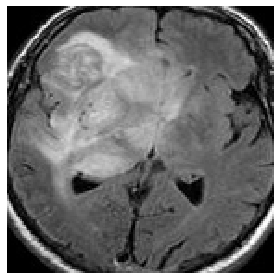

Reduced Size



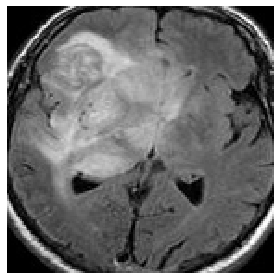

TE_input


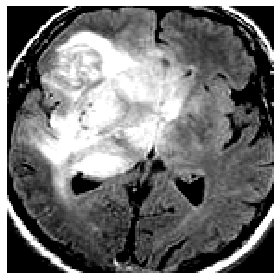

TE_create_mask:


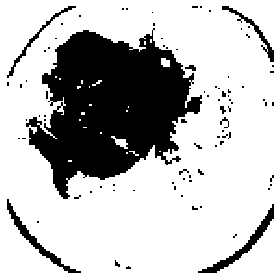

TE_masked_image send next:


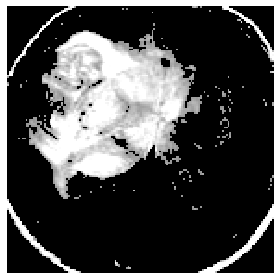

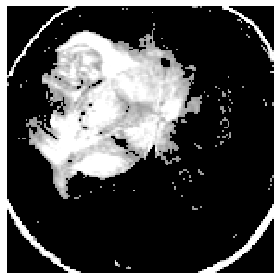

print----


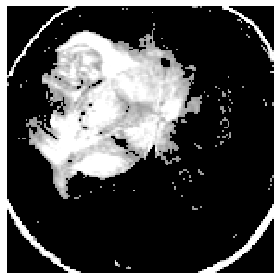

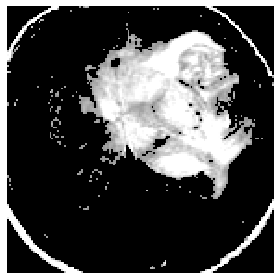

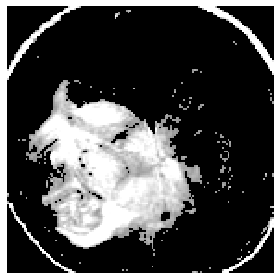

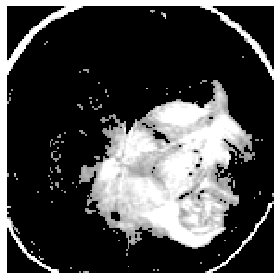

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


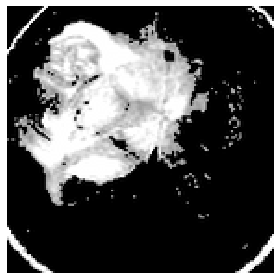

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


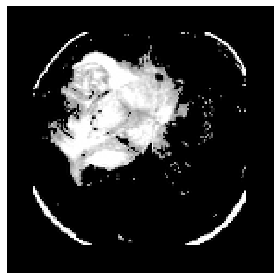

print----


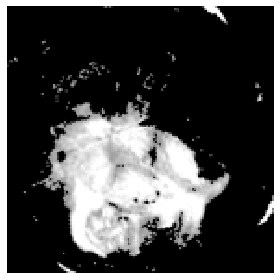

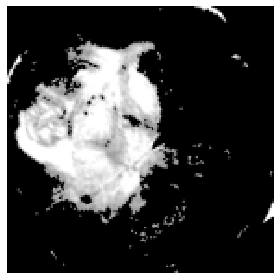

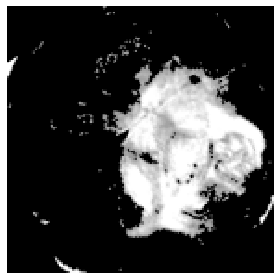

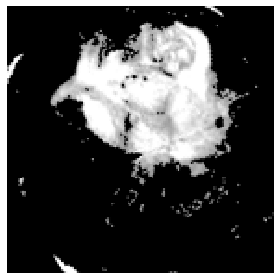

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


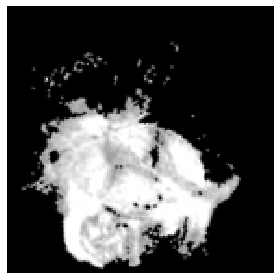

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


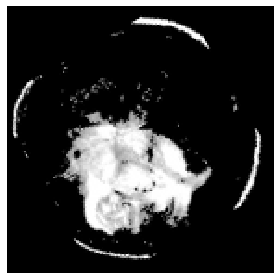

print----


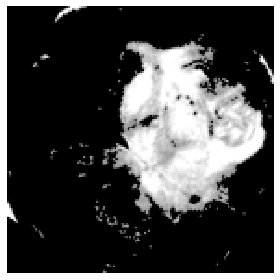

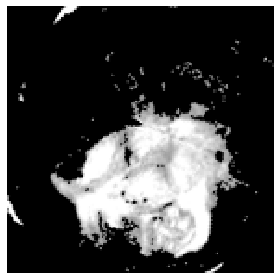

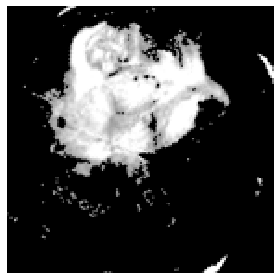

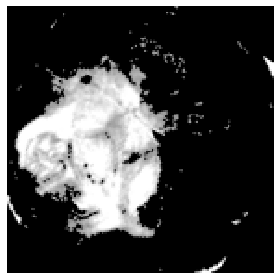

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


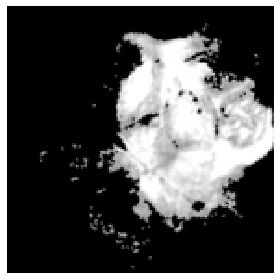

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


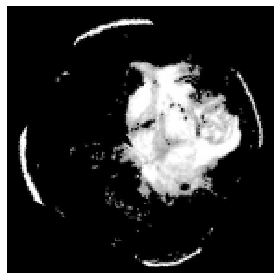

In [ ]:
from PIL import Image
img_loc = '/content/drive/MyDrive/Data/BrainTumorDataset/yes/Y2.jpg' #/content/drive/MyDrive/Data/BrainTumorDataset/no/21 no.jpg
im = Image.open(img_loc)
pr_im = _get_processed_numpy_img(im)
im_view_console(pr_im)
im = convert_pil_2_matplt_im(pr_im)

zoomIn = zoom_image(im,1.1) #4 0.70, 0.90, 1.10, 1.30
zoomOut = zoom_image(im,0.8)
#im_view_console(zoomIn)
#im_view_console(zoomOut)

#Augmentation sample
#Dataset Augmented
ROTATE_ANGLE = 120 #30
MAIN_LOOP = int(360 / ROTATE_ANGLE)

for i in range(0,MAIN_LOOP): #0 to 11, before 12
    a = rotate_image(im, ROTATE_ANGLE*i)
    b = rotate_image(flip_lr(im),ROTATE_ANGLE*i)
    c = rotate_image(flip_ud(im),ROTATE_ANGLE*i)
    d = rotate_image(flip_ud_lr(im),ROTATE_ANGLE*i)
    e = rotate_image(zoom_image(im,1.1),ROTATE_ANGLE*i)
    f = rotate_image(zoom_image(im,0.8),ROTATE_ANGLE*i)

    print("print----")
    im_view_console(a)
    im_view_console(b)
    im_view_console(c)
    im_view_console(d)
    im_view_console(e)
    im_view_console(f)

In [ ]:
import cv2
import os
import numpy as np

file_loc = '/content/drive/MyDrive/Data/BrainTumorDataset'
yes = file_loc+'/yes'
no = file_loc+'/no'
def load_images_from_folder(folder):
    count = 0
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(_get_processed_numpy_img(img))
            count += 1
    print('Input count: ',count)
    return images

In [ ]:
image_yes = load_images_from_folder(yes)
label_yes = np.arange(len(image_yes))
label_yes.fill(1)

image_no = load_images_from_folder(no)
label_no = np.arange(len(image_no))
label_no.fill(0)

#DATASET building

In [ ]:
image_yes = np.asarray(image_yes)
label_yes = np.asarray(label_yes)
image_no = np.asarray(image_no)
label_no = np.asarray(label_no)

dataset_image = np.concatenate((image_yes,image_no))
dataset_label = np.concatenate((label_yes,label_no))

In [ ]:
print(dataset_image.shape,' TYPE: ', type(dataset_image))
print(dataset_label.shape,' TYPE: ', type(dataset_label))
print(dataset_label)
im_view_console(dataset_image[21])

#DATASET augementation

In [ ]:
imgClass = ['Nevus','Tumor']

#Dataset Augmented
ROTATE_ANGLE = 120 #30
MAIN_LOOP = int(360 / ROTATE_ANGLE)
datasetAugSet = []
datasetAugLabel = []

for x in range(0, len(dataset_image)):
    for i in range(0,MAIN_LOOP): #0 to 11, before 12
        datasetAugSet.append(rotate_image(dataset_image[x], ROTATE_ANGLE*i))
        datasetAugSet.append(rotate_image(flip_lr(dataset_image[x]),ROTATE_ANGLE*i))
        datasetAugSet.append(rotate_image(flip_ud(dataset_image[x]),ROTATE_ANGLE*i))
        datasetAugSet.append(rotate_image(flip_ud_lr(dataset_image[x]),ROTATE_ANGLE*i))
        datasetAugSet.append(rotate_image(zoom_image(dataset_image[x],1.1),ROTATE_ANGLE*i))
        datasetAugSet.append(rotate_image(zoom_image(dataset_image[x],0.8),ROTATE_ANGLE*i))
        for j in range(0,6): #0 to 4, before 5
            datasetAugLabel.append(dataset_label[x])

datasetAugSet = np.asanyarray(datasetAugSet)
datasetAugLabel = np.asanyarray(datasetAugLabel)

In [ ]:
print(datasetAugSet.shape)
print(datasetAugLabel.shape)
#datasetAugSet = dataset_image
#datasetAugLabel = dataset_label

#PLOT ALL IMAGE

In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(datasetAugSet, datasetAugLabel,50)

#SPLIT dataset: Train-Test-Validation

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:

* data70% of the data for training.
* 15% of the data for validation.
* 15% of the data for testing.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(datasetAugSet, datasetAugLabel, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

#KEYS model

In [ ]:
def model_history_keys(model):
    modelHistory = model.history
    print(modelHistory)
    for key in modelHistory.keys():
        print(key)
    return modelHistory

#PLOT: loss & accuracy

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

#CONFUSION matrix & F1

In [ ]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_values(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel() #param = (true, pred)
    print('TN= ',tn,'\nFP= ', fp,'\nFN= ', fn,'\nTP= ', tp)

    sensitivity_or_recall = tp / (tp + fn)
    specificity_or_tn = tn / (tn + fp)
    precision_or_ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    accu = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2* (precision_or_ppv * sensitivity_or_recall) / (precision_or_ppv + sensitivity_or_recall)

    print('sensitivity_or_recall: ',sensitivity_or_recall*100,'%')
    print('specificity_or_tn: ',specificity_or_tn*100,'%')
    print('precision_or_ppv: ',precision_or_ppv*100,'%')
    print('NPV: ',npv*100,'%')
    print('ACCU: ',accu*100,'%')
    print('F1: ',f1_score*100,'%')
    print('\n\n')

#SAVE model

In [ ]:
def _save_dnn_model(model_name):
    modelSavePath = '/content/drive/My Drive/Brain_Tumor_Saved_Model'
    import time
    t = time.time()
    outPath = "/{}.h5".format(int(t))
    totalModelPath = modelSavePath+outPath
    print(totalModelPath)
    model_name.save(totalModelPath)

#OPTIMZIED cnn (Dropout)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.2


In [ ]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Conv2D(128,(7,7),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((3,3),strides=3))
model_cnn.add(tf.keras.layers.Conv2D(64,(4,4),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((3,3),strides=3))
model_cnn.add(tf.keras.layers.Conv2D(32,(5,5),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((2,2),strides=2))
model_cnn.add(tf.keras.layers.Conv2D(128,(6,6),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((3,3),strides=3))
model_cnn.add(tf.keras.layers.Conv2D(32,(5,5),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((2,2),strides=2))
model_cnn.add(tf.keras.layers.Conv2D(128,(6,6),padding='same', activation=tf.nn.relu,input_shape=(desired_size,desired_size,image_dim)))
model_cnn.add(tf.keras.layers.MaxPool2D((2,2),strides=2))

avg_pool = tf.keras.Sequential()
avg_pool.add(tf.keras.layers.AveragePooling2D())
avg_pool.add(tf.keras.layers.Flatten())
avg_pool.add(keras.layers.Dense(512, activation=tf.nn.relu))
avg_pool.add(keras.layers.Dropout(0.4))
avg_pool.add(keras.layers.Dense(128, activation=tf.nn.relu))
avg_pool.add(keras.layers.Dropout(0.3))
avg_pool.add(keras.layers.Dense(64, activation=tf.nn.relu))
avg_pool.add(keras.layers.Dense(512, activation=tf.nn.relu))
avg_pool.add(keras.layers.Dropout(0.6))
avg_pool.add(keras.layers.Dense(512, activation=tf.nn.relu))
avg_pool.add(keras.layers.Dropout(0.3))
avg_pool.add(keras.layers.Dense(64, activation=tf.nn.relu))
avg_pool = tf.keras.layers.GlobalAveragePooling2D()

prediction = keras.layers.Dense(2, activation=tf.nn.softmax)

opt_model_cnn = tf.keras.Sequential([
     model_cnn,
     avg_pool,
     prediction
    ])
opt_model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#OPTIMIZED cnn (Train)

In [ ]:
#all model input param is numpyarray type
#trainSet4Dim = np.expand_dims(trainAugSet, axis=-1) #convert to 4 dim as Convo2d supports 4 dim
#testSet4Dim = np.expand_dims(testSet, axis=-1) #convert to 4 dim as Convo2d supports 4 dim
modelHistory_opt_cnn = opt_model_cnn.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_val,y_val))

#OPTIMIZED cnn (Evaluation)

In [ ]:
opt_cnn_hist = model_history_keys(modelHistory_opt_cnn)

test_loss, test_accu = opt_model_cnn.evaluate(X_test, y_test)
print('\nTest accuracy: ',test_accu*100,'%')

plot_metrics(opt_cnn_hist)
#_save_dnn_model(opt_model_cnn)

#OPTIMIZED cnn (Prediction)

In [ ]:
#_save_cnn_model(model)
#Prediction
prediction = opt_model_cnn.predict(X_test)
print('Original vs Prediction\n')
pos = 0
#print(prediction)
predLabel = []
for i in range(0, len(prediction)):
    predLabel.append(np.argmax(prediction[i]))
    #print(imgClass[testLabel[i]],'>> <<',imgClass[np.argmax(prediction[i])])
predLabel = np.asarray(predLabel)
print(y_test)
print(predLabel)
confusion_matrix_values(y_test,predLabel)

#VGG 16-PT (Pre-Trained model)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
from tensorflow.keras import optimizers

vgg16net = VGG16(include_top=False, weights='imagenet', input_shape=(desired_size, desired_size,3))

output = vgg16net.layers[-1].output
output = keras.layers.Flatten()(output)
vgg16net = Model(vgg16net.input, output)
for layer in vgg16net.layers:
    layer.trainable = False

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_vgg16net = Sequential()
model_vgg16net.add(vgg16net)
model_vgg16net.add(Dense(512, activation='relu', input_shape=(desired_size,desired_size,3)))
model_vgg16net.add(Dropout(0.6))
model_vgg16net.add(Dense(512, activation='relu'))
model_vgg16net.add(Dropout(0.5))
model_vgg16net.add(Dense(128, activation='relu'))
model_vgg16net.add(Dropout(0.3))
model_vgg16net.add(Dense(2, activation=tf.nn.softmax))
model_vgg16net.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),metrics=['accuracy'])
#model_vgg16net.summary()

#VGG 16-PT (Train & Evaluation)

In [ ]:
import numpy as np
import pandas as pd
import shutil
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

vgg16model = model_vgg16net.fit(X_train,y_train,epochs=50, validation_data=(X_val,y_val))
test_loss3, test_accu3 = model_vgg16net.evaluate(X_test,y_test)
print('\nTest accuracy: ',test_accu3*100,'%')

#VGG 16-PT (Prediction)

In [ ]:
#_save_dnn_model(model_vgg16net)
#Prediction
prediction = model_vgg16net.predict(X_test)
print('Original vs Prediction\n')
pos = 0
predLabel = []
#print(prediction)
for i in range(0, len(prediction)):
    predLabel.append(np.argmax(prediction[i]))
    #print(imgClass[testLabel[i]],'>> <<',imgClass[np.argmax(prediction[i])])

vgg16_hist_ft = model_history_keys(vgg16model)
plot_metrics(vgg16_hist_ft)

print(y_test)
print(predLabel)
confusion_matrix_values(y_test,predLabel)

#VGG 16-TF model (Transfer Learning)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
vgg16net_tf = VGG16(include_top=False, weights='imagenet', input_shape=(desired_size, desired_size,3))

output = vgg16net_tf.layers[-1].output
output = keras.layers.Flatten()(output)
vgg16net_tf = Model(vgg16net_tf.input, output)

for layer in vgg16net_tf.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(vgg16net_tf.layers):
    print(i, layer.name, layer.trainable)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
model_vgg16net_tf = Sequential()
model_vgg16net_tf.add(vgg16net_tf)
model_vgg16net_tf.add(Dense(512, activation='relu', input_shape=(desired_size,desired_size,3)))#1
model_vgg16net_tf.add(Dropout(0.6))
model_vgg16net_tf.add(Dense(512, activation='relu'))#2
model_vgg16net_tf.add(Dropout(0.5))
model_vgg16net_tf.add(Dense(128, activation='relu'))#3
model_vgg16net_tf.add(Dropout(0.3))
model_vgg16net_tf.add(Dense(2, activation=tf.nn.softmax))#output
model_vgg16net_tf.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),metrics=['accuracy'])#5
model_vgg16net_tf.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_2 True
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 8192)              14714688  
                                                                 
 dense_7 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 51

#VGG 16-TF (Train & Evaluation)

In [ ]:
import numpy as np
import pandas as pd
import shutil
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

vgg16model_tf = model_vgg16net_tf.fit(X_train,y_train,epochs=30, validation_data=(X_val,y_val))
test_loss3, test_accu3 = model_vgg16net_tf.evaluate(X_test,y_test)
print('\nTest accuracy: ',test_accu3*100,'%')

#VGG 16-TF (Prediction)

In [ ]:
#_save_dnn_model(model_vgg16net_tf)
#Prediction
prediction = model_vgg16net_tf.predict(X_test)
print('Original vs Prediction\n')
pos = 0
predLabel = []
#print(prediction)
for i in range(0, len(prediction)):
    predLabel.append(np.argmax(prediction[i]))
confusion_matrix_values(y_test,predLabel)

vgg16_hist_tf = model_history_keys(vgg16model_tf)
plot_metrics(vgg16_hist_tf)

#VIEW SAVED MODEL

In [ ]:
"""
#See saved model summery
from tensorflow import keras
modelPath = '/content/drive/My Drive/Skin-Cancer-Saved-Model/canny_62.85v2.h5'
savedModel = keras.models.load_model(modelPath)
savedModel.summary()
#keras.utils.plot_model(savedModel,"CNN Model.png", show_shapes=True) #print in/out Model as images
#test_loss, test_accu = savedModel.evaluate(testSet,testLabel)
model = savedModel #PREDICTION_SET_VIEW
#print('\nTest accuracy: ',test_accu*100,'%')
"""